In [1278]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import StandardScaler
from tabulate import tabulate

In [1279]:
# # Load the dataset
data = pd.read_csv("day.csv")

# Convert 'dteday' to datetime if not already
data['dteday'] = pd.to_datetime(data['dteday'], errors='coerce')

# Convert 'dteday' to numeric (e.g., days since the minimum date in the dataset)
data['dteday_numeric'] = (data['dteday'] - data['dteday'].min()).dt.days

# Drop the original datetime column if needed
data = data.drop(columns=['dteday'])

# Drop the fields 
# -instant (an identifier).
# -holiday (low correlation with cnt).
# -weekday (low correlation with cnt).
# -atemp or temp (high correlation).
# -windspeed (low correlation with cnt).
columns_to_exclude = ['instant', 'holiday', 'weekday', 'atemp', 'windspeed']

X = data.drop(columns=columns_to_exclude + ['cnt'], axis=1)  
y = data['cnt']

## BUILT-IN

### Train the model

In [1280]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Polynomial Features
poly = PolynomialFeatures(degree=4) 
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

### Evaluate

In [1281]:
# MAE (Mean Absolute Error)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# NRMSE (Normalized RMSE): RMSE divided by the range of target variable
train_nrmse = train_rmse / (y_train.max() - y_train.min())
test_nrmse = test_rmse / (y_test.max() - y_test.min())

# R² (Coefficient of Determination)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate the range of 'cnt'
cnt_min = y.min()  # Minimum value of cnt
cnt_max = y.max()  # Maximum value of cnt
cnt_range = cnt_max - cnt_min

print(f"Range of cnt: {cnt_range} (min: {cnt_min}, max: {cnt_max})")

# Print the metrics
print("Evaluation Metrics for Polynomial Regression:")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train NRMSE: {train_nrmse}")
print(f"Test NRMSE: {test_nrmse}")
print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

Range of cnt: 8692 (min: 22, max: 8714)
Evaluation Metrics for Polynomial Regression:
Train MAE: 1.7578659045617526
Test MAE: 11.97159291292556
Train RMSE: 2.307861189461002
Test RMSE: 40.733455098326374
Train NRMSE: 0.0002786262452566705
Test NRMSE: 0.005001038072231599
Train R²: 0.9999985470112069
Test R²: 0.9995862186855282


### Evaluation of Metrics

##### Range of `cnt`:
- **Range**: 8692 (min: 22, max: 8714)
- The large range means that the MAE and RMSE values should be interpreted relative to this scale.

##### Train/Test MAE:
- **Train MAE**: 1.76  
- **Test MAE**: 11.97  
    - These are very small compared to the range of `cnt`. For example, the Test MAE (11.97) represents an average error of only about **0.14%** relative to the range:  
    \[
    \text{Test MAE relative to range} = \frac{11.97}{8692} \approx 0.14\%
    \]

##### Train/Test RMSE:
- **Train RMSE**: 2.31  
- **Test RMSE**: 40.73  
    - The RMSE is still very small compared to the target range.  
    - Test RMSE is higher than the training RMSE, but this is expected and indicates the model is slightly more accurate on the training set (a common occurrence).

##### Train/Test NRMSE:
- **Train NRMSE**: 0.00028  
- **Test NRMSE**: 0.005  
    - Normalized RMSE is less than **1%** of the range for both sets, indicating excellent performance.

##### Train/Test \(R^2\):
- **Train \(R^2\)**: 0.9999985  
- **Test \(R^2\)**: 0.999586  
    - Both are very close to **1.0**, indicating the model explains nearly all of the variance in the target variable.  
    - The slight drop in Test \(R^2\) compared to Train \(R^2\) is acceptable and suggests the model generalizes well.


Cross-Validation

In [1282]:
# Create a pipeline for polynomial features and linear regression
pipeline = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')  # 5-fold CV

# Convert scores to positive values (since they're negative for MAE)
cv_scores = -cv_scores

print("Cross-Validation Results:")
print(f"MAE Scores for each fold: {cv_scores}")
print(f"Mean MAE: {cv_scores.mean()}")
print(f"Standard Deviation of MAE: {cv_scores.std()}")

Cross-Validation Results:
MAE Scores for each fold: [8.75094283e-05 1.07570790e-05 1.97343448e-05 1.94398135e-05
 7.15348876e-06]
Mean MAE: 2.891883086527614e-05
Standard Deviation of MAE: 2.9700653227044237e-05


In [1283]:
# Calculate residuals for training and test sets
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

Residual Standard Deviation: Measures the spread of errors. Smaller standard deviations indicate more consistent predictions.

In [1284]:
# Standard deviation of residuals
train_std = np.std(train_residuals)
test_std = np.std(test_residuals)

print(f"Train Residual Standard Deviation: {train_std}")
print(f"Test Residual Standard Deviation: {test_std}")

Train Residual Standard Deviation: 2.307861189461002
Test Residual Standard Deviation: 40.438373019372094


Confidence Intervals: Indicate the range within which metrics like MAE are expected to fall with 95% confidence. Smaller intervals signify higher confidence in the metrics.

In [1285]:
# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2., len(data) - 1)
    return mean - margin, mean + margin

# Confidence intervals for MAE
train_mae_ci = confidence_interval(np.abs(train_residuals))
test_mae_ci = confidence_interval(np.abs(test_residuals))

print(f"Train MAE Confidence Interval: {train_mae_ci}")
print(f"Test MAE Confidence Interval: {test_mae_ci}")

Train MAE Confidence Interval: (np.float64(1.6362291145029089), np.float64(1.8795026946205964))
Test MAE Confidence Interval: (np.float64(5.603328569750606), np.float64(18.339857256100515))


Residual Distribution: Should ideally be symmetric and centered around 0, indicating no systematic bias in predictions.

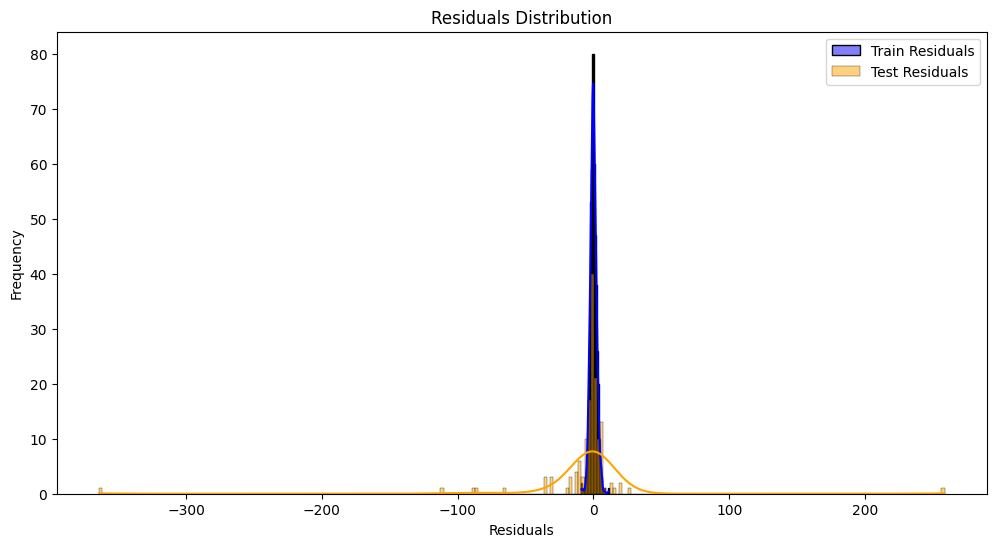

In [1286]:
# Plot residual distributions
plt.figure(figsize=(12, 6))

sns.histplot(train_residuals, kde=True, color="blue", label="Train Residuals")
sns.histplot(test_residuals, kde=True, color="orange", label="Test Residuals")

plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Summary Table

In [1287]:
# Create a summary dataframe specifically for MAE
mae_summary = pd.DataFrame({
    "Metric": ["MAE"],
    "Train Value": [train_mae],
    "Test Value": [test_mae],
    "Train Std Dev": [train_std],
    "Test Std Dev": [test_std],
    "Train CI": [train_mae_ci],
    "Test CI": [test_mae_ci]
})

print(tabulate(mae_summary, headers='keys', tablefmt='pretty'))

+---+--------+--------------------+-------------------+-------------------+--------------------+------------------------------------------------------------------+-----------------------------------------------------------------+
|   | Metric |    Train Value     |    Test Value     |   Train Std Dev   |    Test Std Dev    |                             Train CI                             |                             Test CI                             |
+---+--------+--------------------+-------------------+-------------------+--------------------+------------------------------------------------------------------+-----------------------------------------------------------------+
| 0 |  MAE   | 1.7578659045617526 | 11.97159291292556 | 2.307861189461002 | 40.438373019372094 | (np.float64(1.6362291145029089), np.float64(1.8795026946205964)) | (np.float64(5.603328569750606), np.float64(18.339857256100515)) |
+---+--------+--------------------+-------------------+-------------------+-----

Feature Importance

In [1288]:
# Get the coefficients from the trained linear regression model
coefficients = model.coef_

# Get the feature names after applying PolynomialFeatures
feature_names = poly.get_feature_names_out(X.columns)

# Combine feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance.head(10))  # Display top 10 features by importance


Feature Importance:
                         Feature  Coefficient  Importance
9                     registered     0.822675    0.822675
8                         casual     0.748924    0.748924
49         weathersit registered     0.345516    0.345516
48             weathersit casual     0.340621    0.340621
234      weathersit^2 registered    -0.184051    0.184051
233          weathersit^2 casual    -0.124986    0.124986
57                    hum casual     0.071565    0.071565
184       mnth weathersit casual    -0.059417    0.059417
35                   mnth casual     0.045981    0.045981
235  weathersit^2 dteday_numeric    -0.045597    0.045597


## SCRATCH

#### Steps to Implement Polynomial Regression from Scratch

##### 1. Generate Polynomial Features
- Manually create polynomial terms (e.g., $x^2, x^3$) and interaction terms for the input features.
- Example:
  - For a single feature $x$, create new features like $[1, x, x^2, x^3]$.
  - For multiple features $x_1$ and $x_2$, include interaction terms like $x_1 \cdot x_2, x_1^2, x_2^2$.


##### 2. Make Predictions
- Use the fitted coefficients $\beta$ to calculate predictions for the target variable:
  $$
  \hat{y} = X \beta
  $$
  Where:
  - $\hat{y}$ is the vector of predicted values.
  - $X$ is the matrix of polynomial features.
  - $\beta$ is the vector of estimated coefficients.



In [1289]:
# Polynomial feature transformation
from itertools import combinations_with_replacement


def polynomial_features(X : np.ndarray, degree: int):
    n_samples, n_features = X.shape
    # Create an array to store polynomial features
    X_poly = np.ones((n_samples, 1))  # Start with the bias (intercept)
    
    # Generate polynomial features
    for d in range(1, degree + 1):
        for combo in combinations_with_replacement(range(n_features), d):
            new_feature = np.prod(X[:, combo], axis=1).reshape(-1, 1)
            X_poly = np.hstack((X_poly, new_feature))
    
    return X_poly

def predict(X, theta):
    return X @ theta

### Evaluation Metrics


#### 1. Mean Absolute Error (MAE)
**Formula:**
$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

**Description:**
- Measures the average magnitude of prediction errors, ignoring their direction.
- Provides a simple interpretation: the average absolute difference between actual values (`yᵢ`) and predicted values (`ŷᵢ`).


In [1290]:
def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true - y_pred)) / n
    return mae

#### 2. Mean Squared Error (MSE)
**Formula:**
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

**Description:**
- Represents the average of the squared differences between actual and predicted values.
- Penalizes larger errors more heavily than MAE due to squaring.


In [1291]:
def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true - y_pred)**2) / n
    return mse

#### 3. Root Mean Squared Error (RMSE)
**Formula:**
$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

**Description:**
- The square root of MSE, which keeps the units of the error in the same scale as the target variable.
- Widely used as it is sensitive to large errors and provides interpretable results.


In [1292]:
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    return rmse

#### 4. Normalized Root Mean Squared Error (NRMSE)
**Formula:**
$$
NRMSE = \frac{RMSE}{y_{\text{max}} - y_{\text{min}}}
$$

**Description:**
- Normalizes RMSE to the range of the target variable.
- Useful for comparing errors across datasets with different scales.


In [1293]:
def normalized_rmse(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    nrmse = rmse / (y_true.max() - y_true.min())
    return nrmse

#### 5. Coefficient of Determination (R²)
**Formula:**
$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

**Description:**
- Measures the proportion of variance in the target variable that is explained by the model.
- Ranges from 0 to 1, where higher values indicate a better fit. A value of 1 indicates perfect predictions.

In [1294]:
def r2_score(y_true, y_pred):
    y_mean = sum(y_true) / len(y_true)
    ss_total = sum((y_true - y_mean)**2)
    ss_residual = sum((y_true - y_pred)**2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

### Gradient Descent 


#### 1. Linear Model Hypothesis:
The hypothesis for linear regression is represented as:

$\hat{y} = X\theta$

In the function, this is computed using:

`X @ theta`

This calculates the predicted values ($\hat{y}$) based on the current parameters ($\theta$).


#### 2. Error Calculation:
The residual error between the predictions ($\hat{y}$) and actual target values ($y$) is:

$\text{Error} = \hat{y} - y = X\theta - y$

In the function, this is implemented as:

`X @ theta - y`


#### 3. Gradient Computation:
To minimize the error, we compute the gradient of the cost function (Mean Squared Error) with respect to $\theta$. The gradient is given by:

$\nabla_\theta J = \frac{2}{n} X^\top (X\theta - y)$

In the function, this is calculated as:

`gradients = (2 / n_samples) * X.T @ (X @ theta - y)`


#### 4. Parameter Update (Gradient Descent):
Using the gradients, the parameters ($\theta$) are updated iteratively to minimize the cost:

$\theta = \theta - \alpha \nabla_\theta J$

In the function, this is done as:

`theta -= learning_rate * gradients`


In [1295]:
# Gradient Descent Implementation for Linear Regression
def gradient_descent(X, y, learning_rate=0.01, iterations=1000, lambda_reg=0.01):
    n_samples, n_features = X.shape
    limit = np.sqrt(6 / (n_features + 1))  # For linear regression, +1 is for the bias term
    theta = np.random.uniform(-limit, limit, n_features)
    cost_history = []

    for _ in range(iterations):
        predictions = X @ theta
        gradients = (2 / n_samples) * X.T @ (predictions - y) + 2 * lambda_reg * theta
        theta -= learning_rate * gradients
        cost = (1 / n_samples) * np.sum((predictions - y) ** 2) + lambda_reg * np.sum(theta[1:] ** 2)
        cost_history.append(cost)

    return theta, cost_history


### Train the model

In [1296]:
lambda_reg=0.000001
cv=5
learning_rate=0.001
degree=4
iterations=100

# Ensure NumPy format
X = np.array(X)
y = np.array(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial transformation
X_train_poly = polynomial_features(X_train, degree)
X_test_poly = polynomial_features(X_test, degree)

model, _ = gradient_descent(X_train_poly, y_train, learning_rate, iterations, lambda_reg)
y_train_pred = X_train_poly @ model
y_test_pred = X_test_poly @ model

In [1297]:
# MAE (Mean Absolute Error)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# RMSE (Root Mean Squared Error)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

# NRMSE (Normalized RMSE): RMSE divided by the range of target variable
train_nrmse = normalized_rmse(y_train, y_train_pred)
test_nrmse = normalized_rmse(y_test, y_test_pred)

# R² (Coefficient of Determination)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate the range of 'cnt'
cnt_min = y.min()  # Minimum value of cnt
cnt_max = y.max()  # Maximum value of cnt
cnt_range = cnt_max - cnt_min


print(f"Range of cnt: {cnt_range} (min: {cnt_min}, max: {cnt_max})")

# Print the metrics
print("Evaluation Metrics for Polynomial Regression:")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train NRMSE: {train_nrmse}")
print(f"Test NRMSE: {test_nrmse}")
print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

Range of cnt: 4.489933909868531 (min: -2.3153992222786273, max: 2.174534687589904)
Evaluation Metrics for Polynomial Regression:
Train MAE: 0.376103260838443
Test MAE: 0.4574397917089552
Train RMSE: 0.5038228377703505
Test RMSE: 0.7201500387025149
Train NRMSE: 0.11775245152840029
Test NRMSE: 0.17116370119337415
Train R²: 0.7404875875759193
Test R²: 0.5152990272887037


### Cross-Validation

In [1298]:
def cross_validate(X, y, degree, learning_rate=0.001, iterations=1000, cv=5, lambda_reg=0.001):

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    cv_errors = []

    # Ensure NumPy format
    X = np.array(X)
    y = np.array(y)

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Polynomial transformation
        X_train_poly = polynomial_features(X_train, degree)
        X_test_poly = polynomial_features(X_test, degree)

        # Train using regularized gradient descent
        theta, _ = gradient_descent(X_train_poly, y_train, learning_rate, iterations, lambda_reg)

        # Predict and calculate MSE
        y_test_pred = X_test_poly @ theta
        mse = mean_absolute_error(y_test, y_test_pred)
        cv_errors.append(mse)

    return np.mean(cv_errors), np.std(cv_errors)


In [1299]:
# Cross-validate
mean_error, std_error = cross_validate(X, y, degree=degree, learning_rate=learning_rate, iterations=iterations, cv=cv, lambda_reg=lambda_reg)
print(f"Mean Error: {mean_error}, Std Dev: {std_error}")


Mean Error: 0.49278241549900514, Std Dev: 0.07877240769926078


In [1300]:
# Calculate residuals for training and test sets
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

In [1301]:
# Standard deviation of residuals
train_std = np.std(train_residuals)
test_std = np.std(test_residuals)

print(f"Train Residual Standard Deviation: {train_std}")
print(f"Test Residual Standard Deviation: {test_std}")

Train Residual Standard Deviation: 0.50381961289473
Test Residual Standard Deviation: 0.7076633914634146


In [1302]:
# Function to calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2., len(data) - 1)
    return mean - margin, mean + margin

# Confidence intervals for MAE
train_mae_ci = confidence_interval(np.abs(train_residuals))
test_mae_ci = confidence_interval(np.abs(test_residuals))

print(f"Train MAE Confidence Interval: {train_mae_ci}")
print(f"Test MAE Confidence Interval: {test_mae_ci}")

Train MAE Confidence Interval: (np.float64(0.34883432495080746), np.float64(0.40337219672607905))
Test MAE Confidence Interval: (np.float64(0.3664648041442182), np.float64(0.548414779273692))


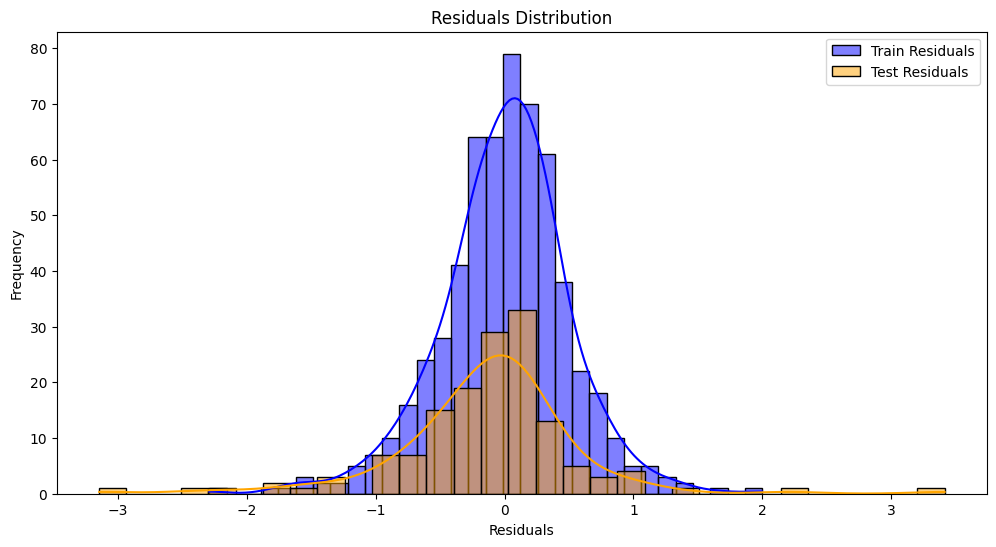

In [1303]:
# Plot residual distributions
plt.figure(figsize=(12, 6))

sns.histplot(train_residuals, kde=True, color="blue", label="Train Residuals")
sns.histplot(test_residuals, kde=True, color="orange", label="Test Residuals")

plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [1304]:
# Create a summary dataframe specifically for MAE
mae_summary = pd.DataFrame({
    "Metric": ["MAE"],
    "Train Value": [train_mae],
    "Test Value": [test_mae],
    "Train Std Dev": [train_std],
    "Test Std Dev": [test_std],
    "Train CI": [train_mae_ci],
    "Test CI": [test_mae_ci]
})

print(tabulate(mae_summary, headers='keys', tablefmt='pretty'))

+---+--------+-------------------+--------------------+------------------+--------------------+--------------------------------------------------------------------+-----------------------------------------------------------------+
|   | Metric |    Train Value    |     Test Value     |  Train Std Dev   |    Test Std Dev    |                              Train CI                              |                             Test CI                             |
+---+--------+-------------------+--------------------+------------------+--------------------+--------------------------------------------------------------------+-----------------------------------------------------------------+
| 0 |  MAE   | 0.376103260838443 | 0.4574397917089552 | 0.50381961289473 | 0.7076633914634146 | (np.float64(0.34883432495080746), np.float64(0.40337219672607905)) | (np.float64(0.3664648041442182), np.float64(0.548414779273692)) |
+---+--------+-------------------+--------------------+------------------+--